In [1]:
!pip install pandas matplotlib wandb numpy

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/52/11/9eac327a38834f162b8250aab32a6781339c69afe7574368fffe46387edf/pandas-2.2.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/0a/e4/300b08e3e08f9c98b0d5635f42edabf2f7a1d634e64cb0318a71a44ff720/matplotlib-3.10.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/49/35/7af15563f7cc40c7ac95f2d2e5ca10fa144d1be20a62da8f475cc7ceebd3/wandb-0.19.9-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/2b/3e/e7247c1d4f15086bb106c8d43c925b0b2ea20270224f5186fa48d4fb5cbd/numpy-2.2.4-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
import pandas as pd


def wandb_viz_loss(exp_data, loss_types=None, save_dir=None, exclude=None, wandb_user='moritz-hauschulz', 
                   wandb_project='structure-preserving-operator-learning', losses=None, vars=None):
    """
    exp_data: list of tuples [(exp_n, label), ...] containing experiment IDs and their labels
    """
    wandb.login()
    # plt.style.use("seaborn-v0_8-whitegrid")
    
    # Set up the figure with high-quality settings
    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
    ax2 = None
    
    # Color cycle for different experiments
    colors = plt.cm.tab10(np.linspace(0, 1, len(exp_data)))
    
    # Line styles for validation vs training
    styles = ['-', '--']
    alphas = [1.0, 0.7]  # Different transparencies for same-color curves
    
    api = wandb.Api()
    all_losses = set()
    
    # First pass: collect all possible loss types
    for exp_n, _ in exp_data:
        run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
        metrics = run.history()
        
        if losses is None:
            for metric in metrics.keys():
                if 'loss' in metric:
                    all_losses.add(metric)
    
    losses = sorted(list(all_losses)) if losses is None else losses
    
    # Second pass: plot all experiments
    for idx, (exp_n, label) in enumerate(exp_data):
        run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
        metrics = run.history()
        
        base_color = colors[idx]
        
        for loss in losses:
            if exclude is not None:
                if any(loss in ex for ex in exclude):
                    continue
                
            style = styles[1] if 'val' in loss else styles[0]
            alpha = alphas[1] if 'val' in loss else alphas[0]
            
            iteration = metrics['epoch']
            loss_data = metrics[loss]
            
            valid_data = [(i, l) for i, l in zip(iteration, loss_data) if not pd.isna(l)]
            
            if not valid_data:
                continue
                
            x, y = zip(*valid_data)
            
            # Determine which axis to use
            if vars and loss in vars:
                if ax2 is None:
                    ax2 = ax1.twinx()
                    ax2.set_ylabel("Secondary Loss Metric", fontsize=14)
                ax2.plot(x, y, label=f"{label} - {loss_types[loss] if loss_types is not None else loss}", linestyle=style, 
                        color=base_color, alpha=alpha, linewidth=2)
            else:
                ax1.plot(x, y, label=f"{label} - {loss_types[loss] if loss_types is not None else loss}", linestyle=style, 
                        color=base_color, alpha=alpha, linewidth=2)
    
    # Styling for publication quality
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14)
    ax1.set_title("Training and Validation Losses", fontsize=16, pad=20)
    
    # Grid and spines
    ax1.grid(True, linestyle='--', alpha=0.7)
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    
    # Legends - moved inside
    if ax2:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        legend = ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, 
                  loc='upper right', bbox_to_anchor=(0.98, 0.98))
    else:
        legend = ax1.legend(fontsize=10, loc='upper right', bbox_to_anchor=(0.98, 0.98))

    plt.tight_layout()
    
    # Save or show
    if save_dir:
        plt.savefig(f"{save_dir}/loss_curves.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()
    
    plt.close()

def wandb_viz_loss_with_std(exp_data, loss_types=None, save_dir=None, exclude=None, wandb_user='moritz-hauschulz', 
                            wandb_project='structure-preserving-operator-learning', losses=None, vars=None):
    """
    exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...] containing labels and their experiment IDs
    """
    wandb.login()
    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
    ax2 = None
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(exp_data)))
    styles = ['-', '--']
    alphas = [1.0, 0.7]
    
    api = wandb.Api()
    all_losses = set()
    
    # Collect all loss types
    for _, exp_ids in exp_data:
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        for exp_n in exp_ids:
            run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
            if losses is None:
                all_losses.update([k for k in run.history().keys() if 'loss' in k])
    
    losses = sorted(list(all_losses)) if losses is None else losses
    
    # Plot experiments
    for idx, (label, exp_ids) in enumerate(exp_data):
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        base_color = colors[idx]
        
        for loss in losses:
            if exclude is not None and any(loss in ex for ex in exclude):
                continue
                
            style = styles[1] if 'val' in loss else styles[0]
            alpha = alphas[1] if 'val' in loss else alphas[0]
            
            # Collect data from all experiments
            all_data = []
            max_epoch = 0
            for exp_n in exp_ids:
                run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
                metrics = run.history()
                iteration = metrics['epoch']
                loss_data = metrics[loss]
                valid_data = [(i, l) for i, l in zip(iteration, loss_data) if not pd.isna(l)]
                if valid_data:
                    x, y = zip(*valid_data)
                    all_data.append((x, y))
                    max_epoch = max(max_epoch, max(x))
            
            if not all_data:
                continue
            
            # If only one experiment, plot normally
            if len(exp_ids) == 1:
                x, y = all_data[0]
                ax = ax2 if vars and loss in vars else ax1
                if ax2 is None and vars and loss in vars:
                    ax2 = ax1.twinx()
                    ax2.set_ylabel("Secondary Loss Metric", fontsize=14)
                ax.plot(x, y, label=f"{label} - {loss_types[loss] if loss_types else loss}", 
                        linestyle=style, color=base_color, alpha=alpha, linewidth=2)
            
            # For multiple experiments, calculate mean and std
            else:
                # Interpolate to common x-axis
                common_x = np.linspace(0, max_epoch, 1000)
                interpolated_y = []
                
                for x, y in all_data:
                    interpolated_y.append(np.interp(common_x, x, y))
                
                mean_y = np.mean(interpolated_y, axis=0)
                std_y = np.std(interpolated_y, axis=0)
                
                ax = ax2 if vars and loss in vars else ax1
                if ax2 is None and vars and loss in vars:
                    ax2 = ax1.twinx()
                    ax2.set_ylabel("Secondary Loss Metric", fontsize=14)
                
                ax.plot(common_x, mean_y, label=f"{label} - {loss_types[loss] if loss_types else loss}", 
                        linestyle=style, color=base_color, alpha=alpha, linewidth=2)
                ax.fill_between(common_x, mean_y-std_y, mean_y+std_y, color=base_color, alpha=0.2)
    
    # Rest of the styling remains the same as in original function
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.set_ylabel("Loss (log)", fontsize=14)
    ax1.set_title("Training and Validation Losses", fontsize=16, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_yscale('log')
    
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    
    if ax2:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        legend = ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10,
                            loc='upper right', bbox_to_anchor=(0.98, 0.98),
                            facecolor='white', edgecolor='black', framealpha=1.0)
    else:
        legend = ax1.legend(fontsize=10, loc='upper right', bbox_to_anchor=(0.98, 0.98),
                            facecolor='white', edgecolor='black', framealpha=1.0)
    
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_alpha(1.0)
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(f"{save_dir}/loss_curves.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()
    
    plt.close()

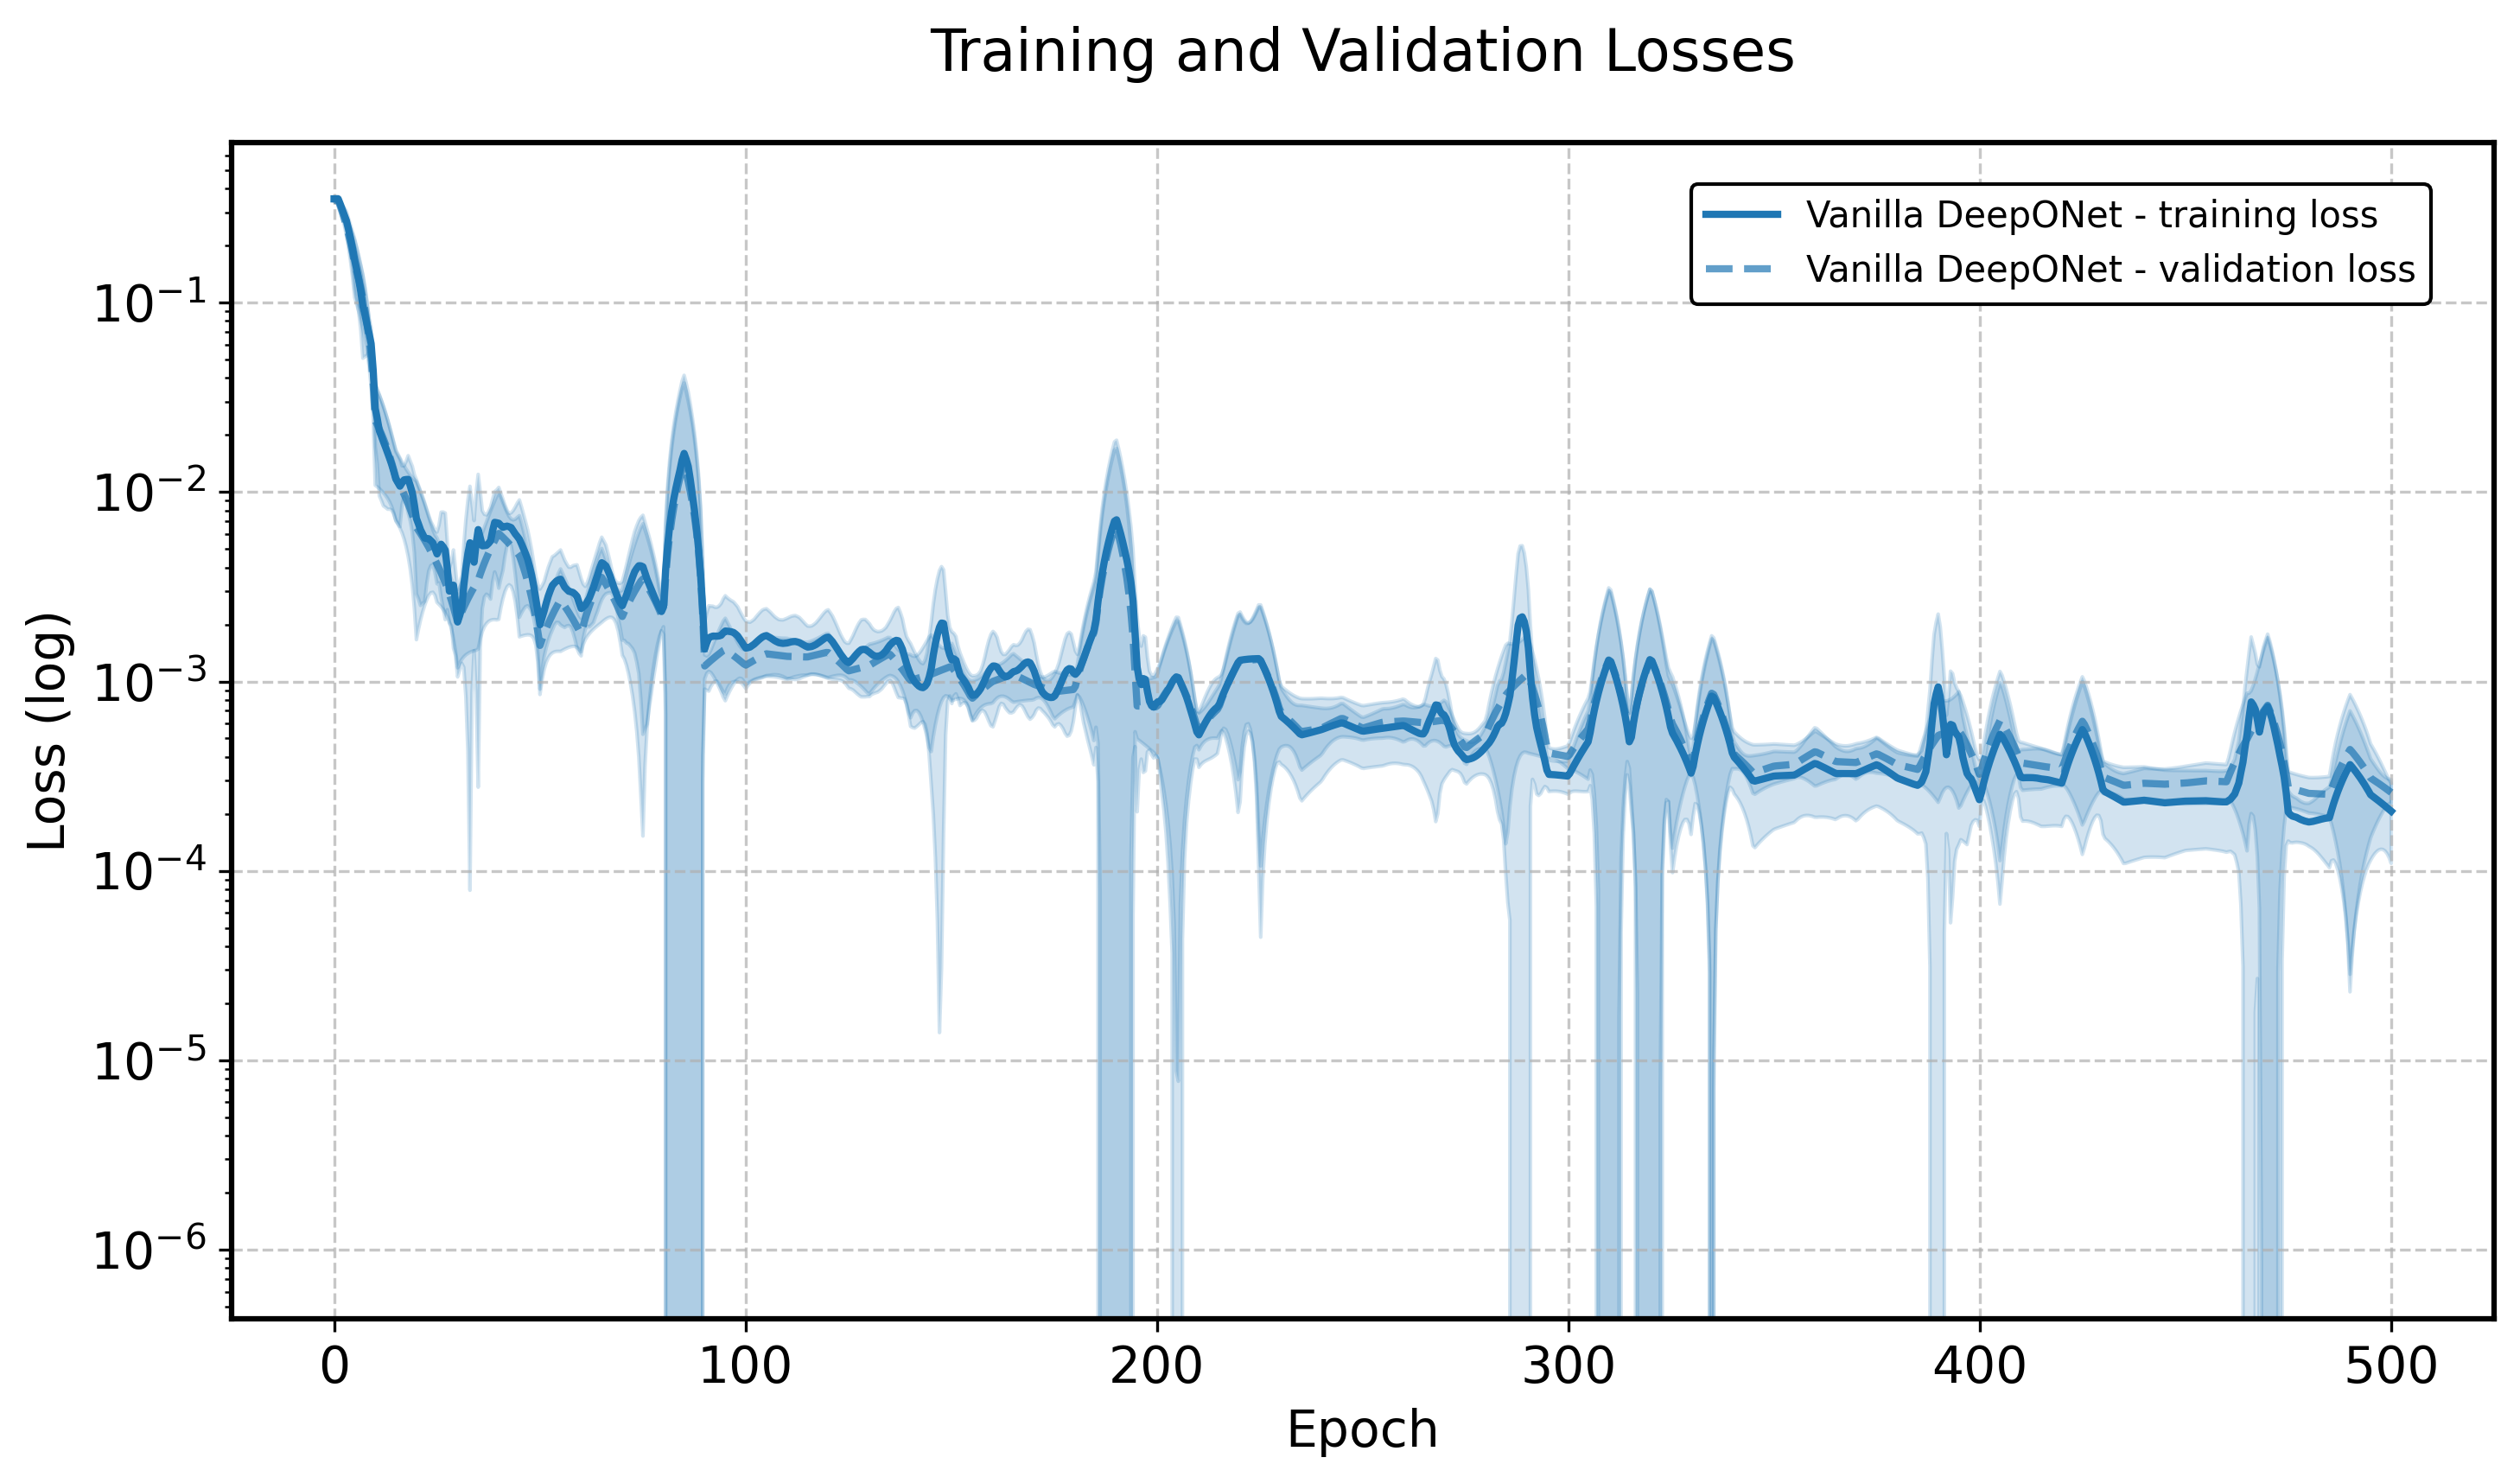

In [96]:
exp_data = [('Vanilla DeepONet',['20250410-113714', '20250410-114150','20250410-042930','20250410-114628','20250410-115127'])]
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss'}
exclude = ['loss_0_train', 'loss_0_val']

wandb_viz_loss_with_std(exp_data, exclude=exclude, loss_types=loss_types)

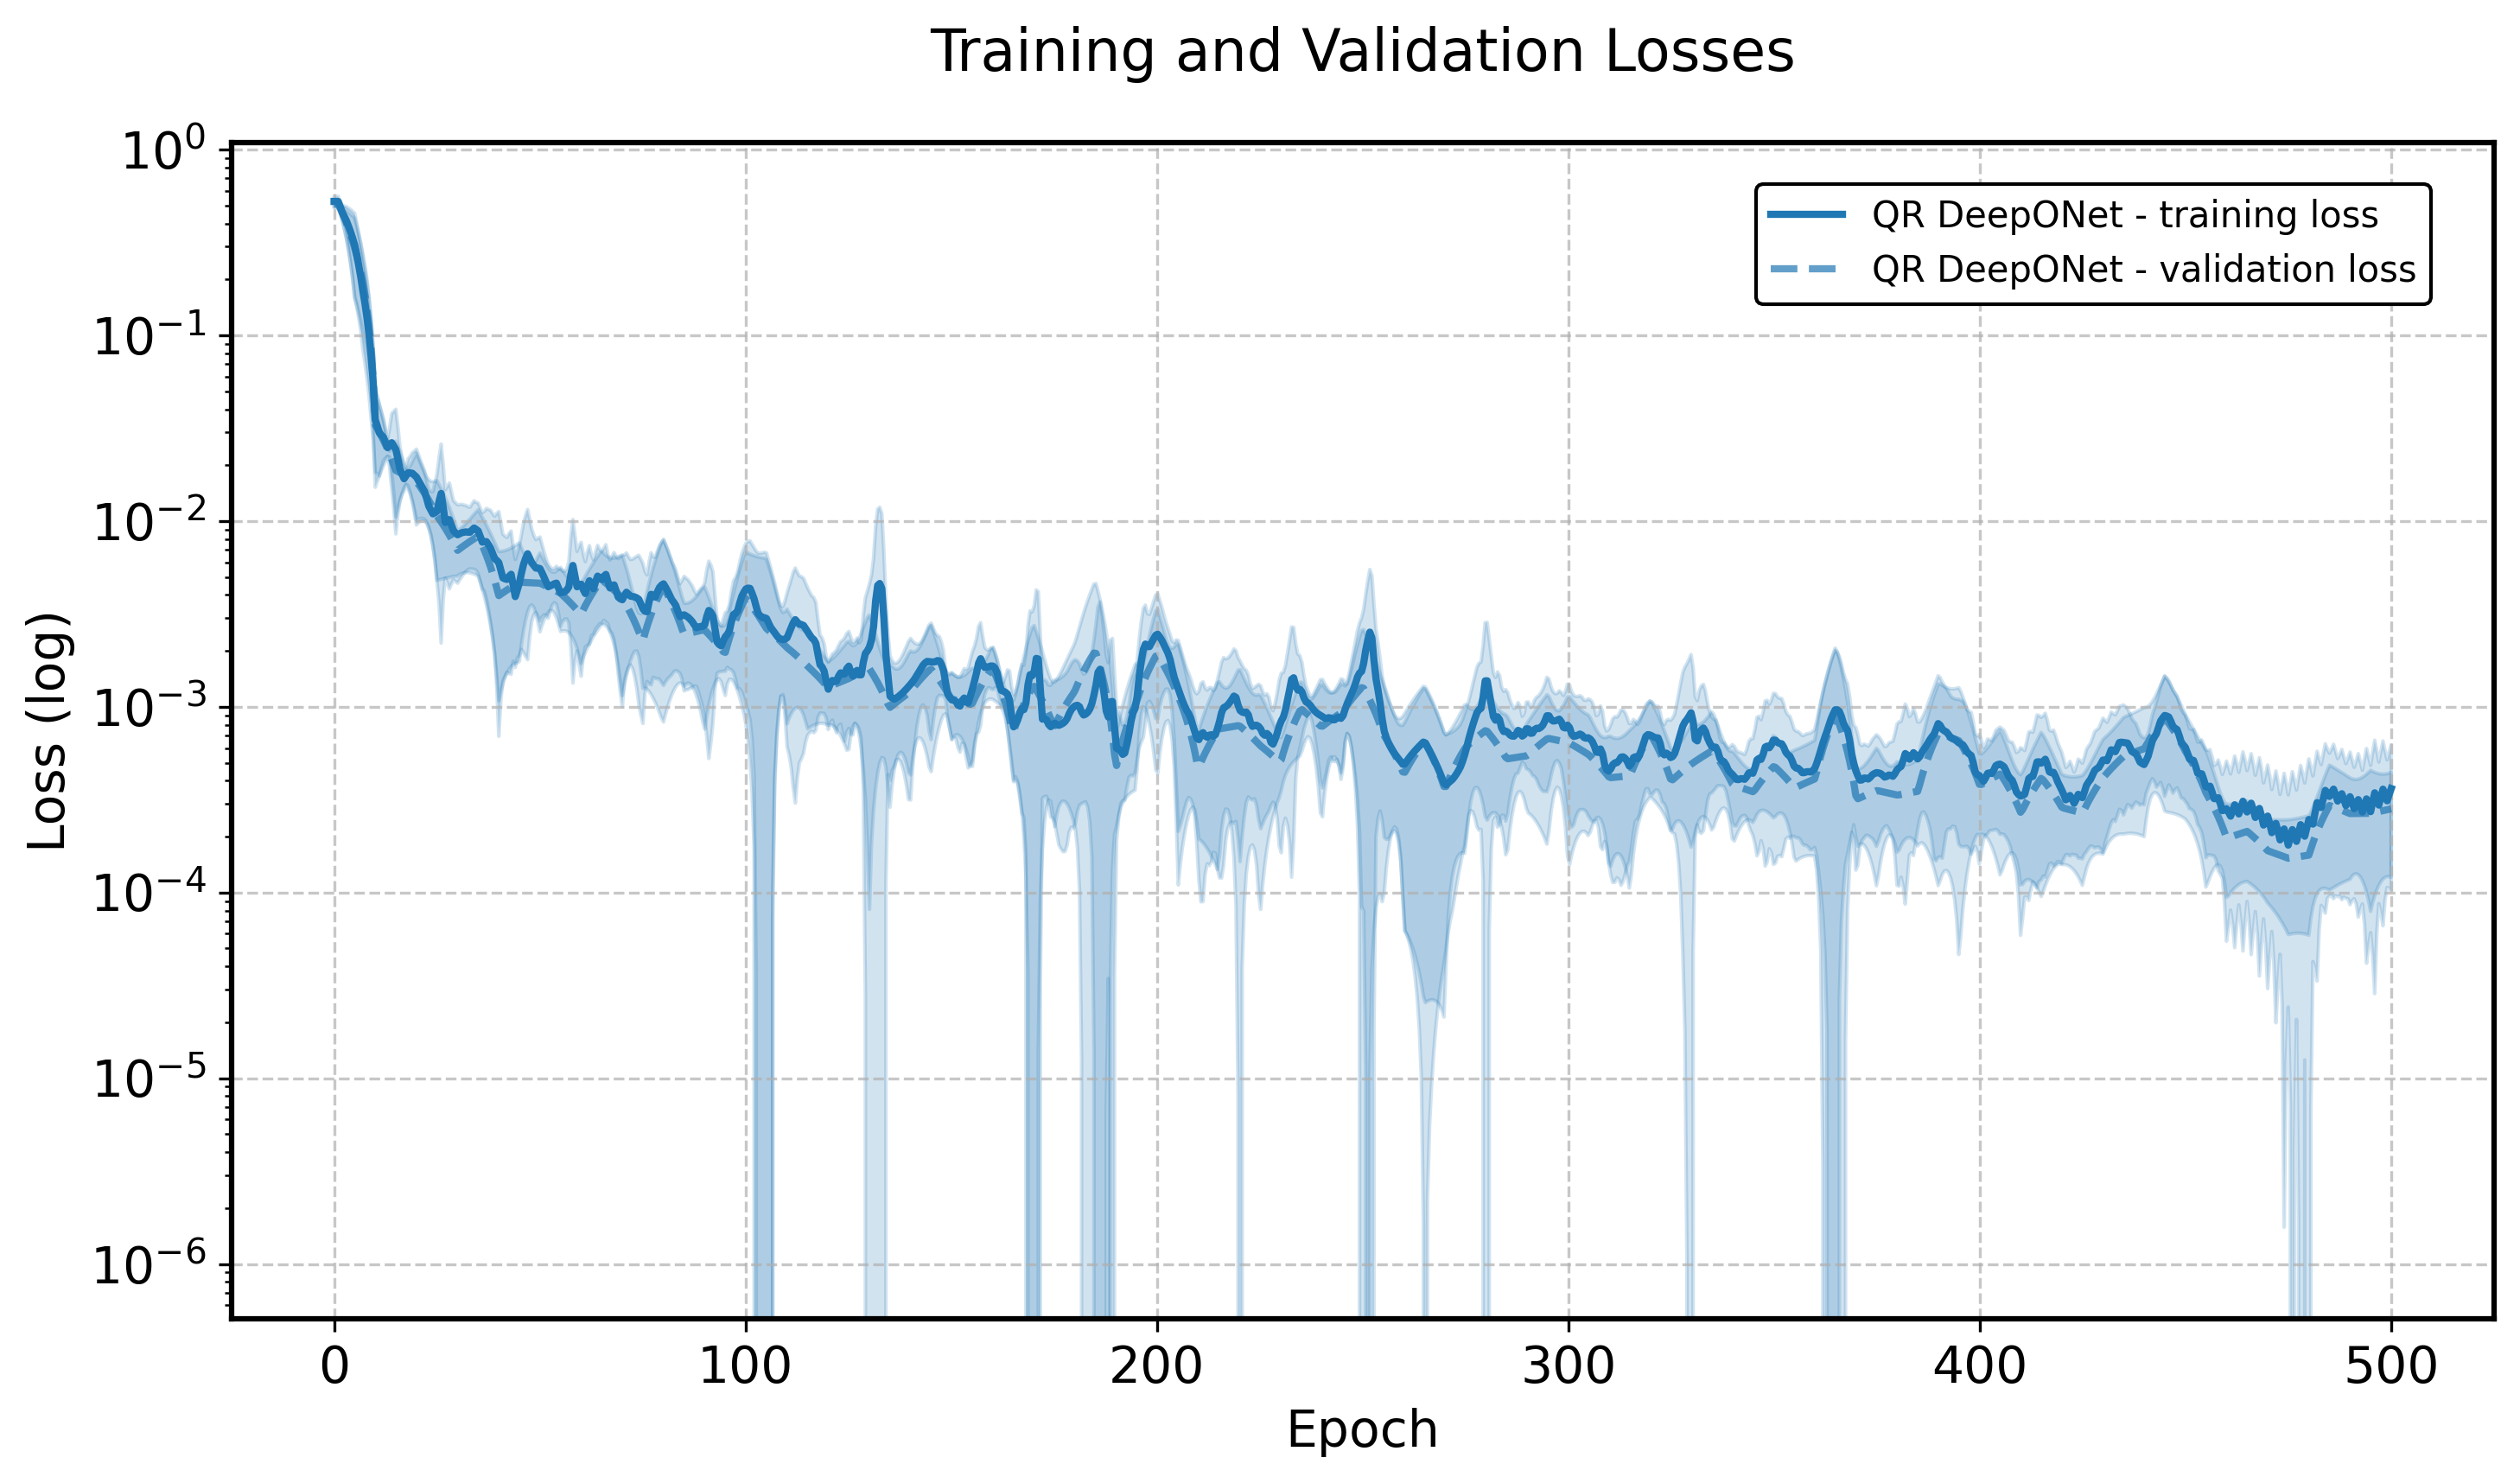

In [97]:
exp_data = [('QR DeepONet',['20250410-121129','20250410-122545','20250410-083757','20250410-123406','20250410-133226'])]

wandb_viz_loss_with_std(exp_data, exclude=exclude, loss_types=loss_types)

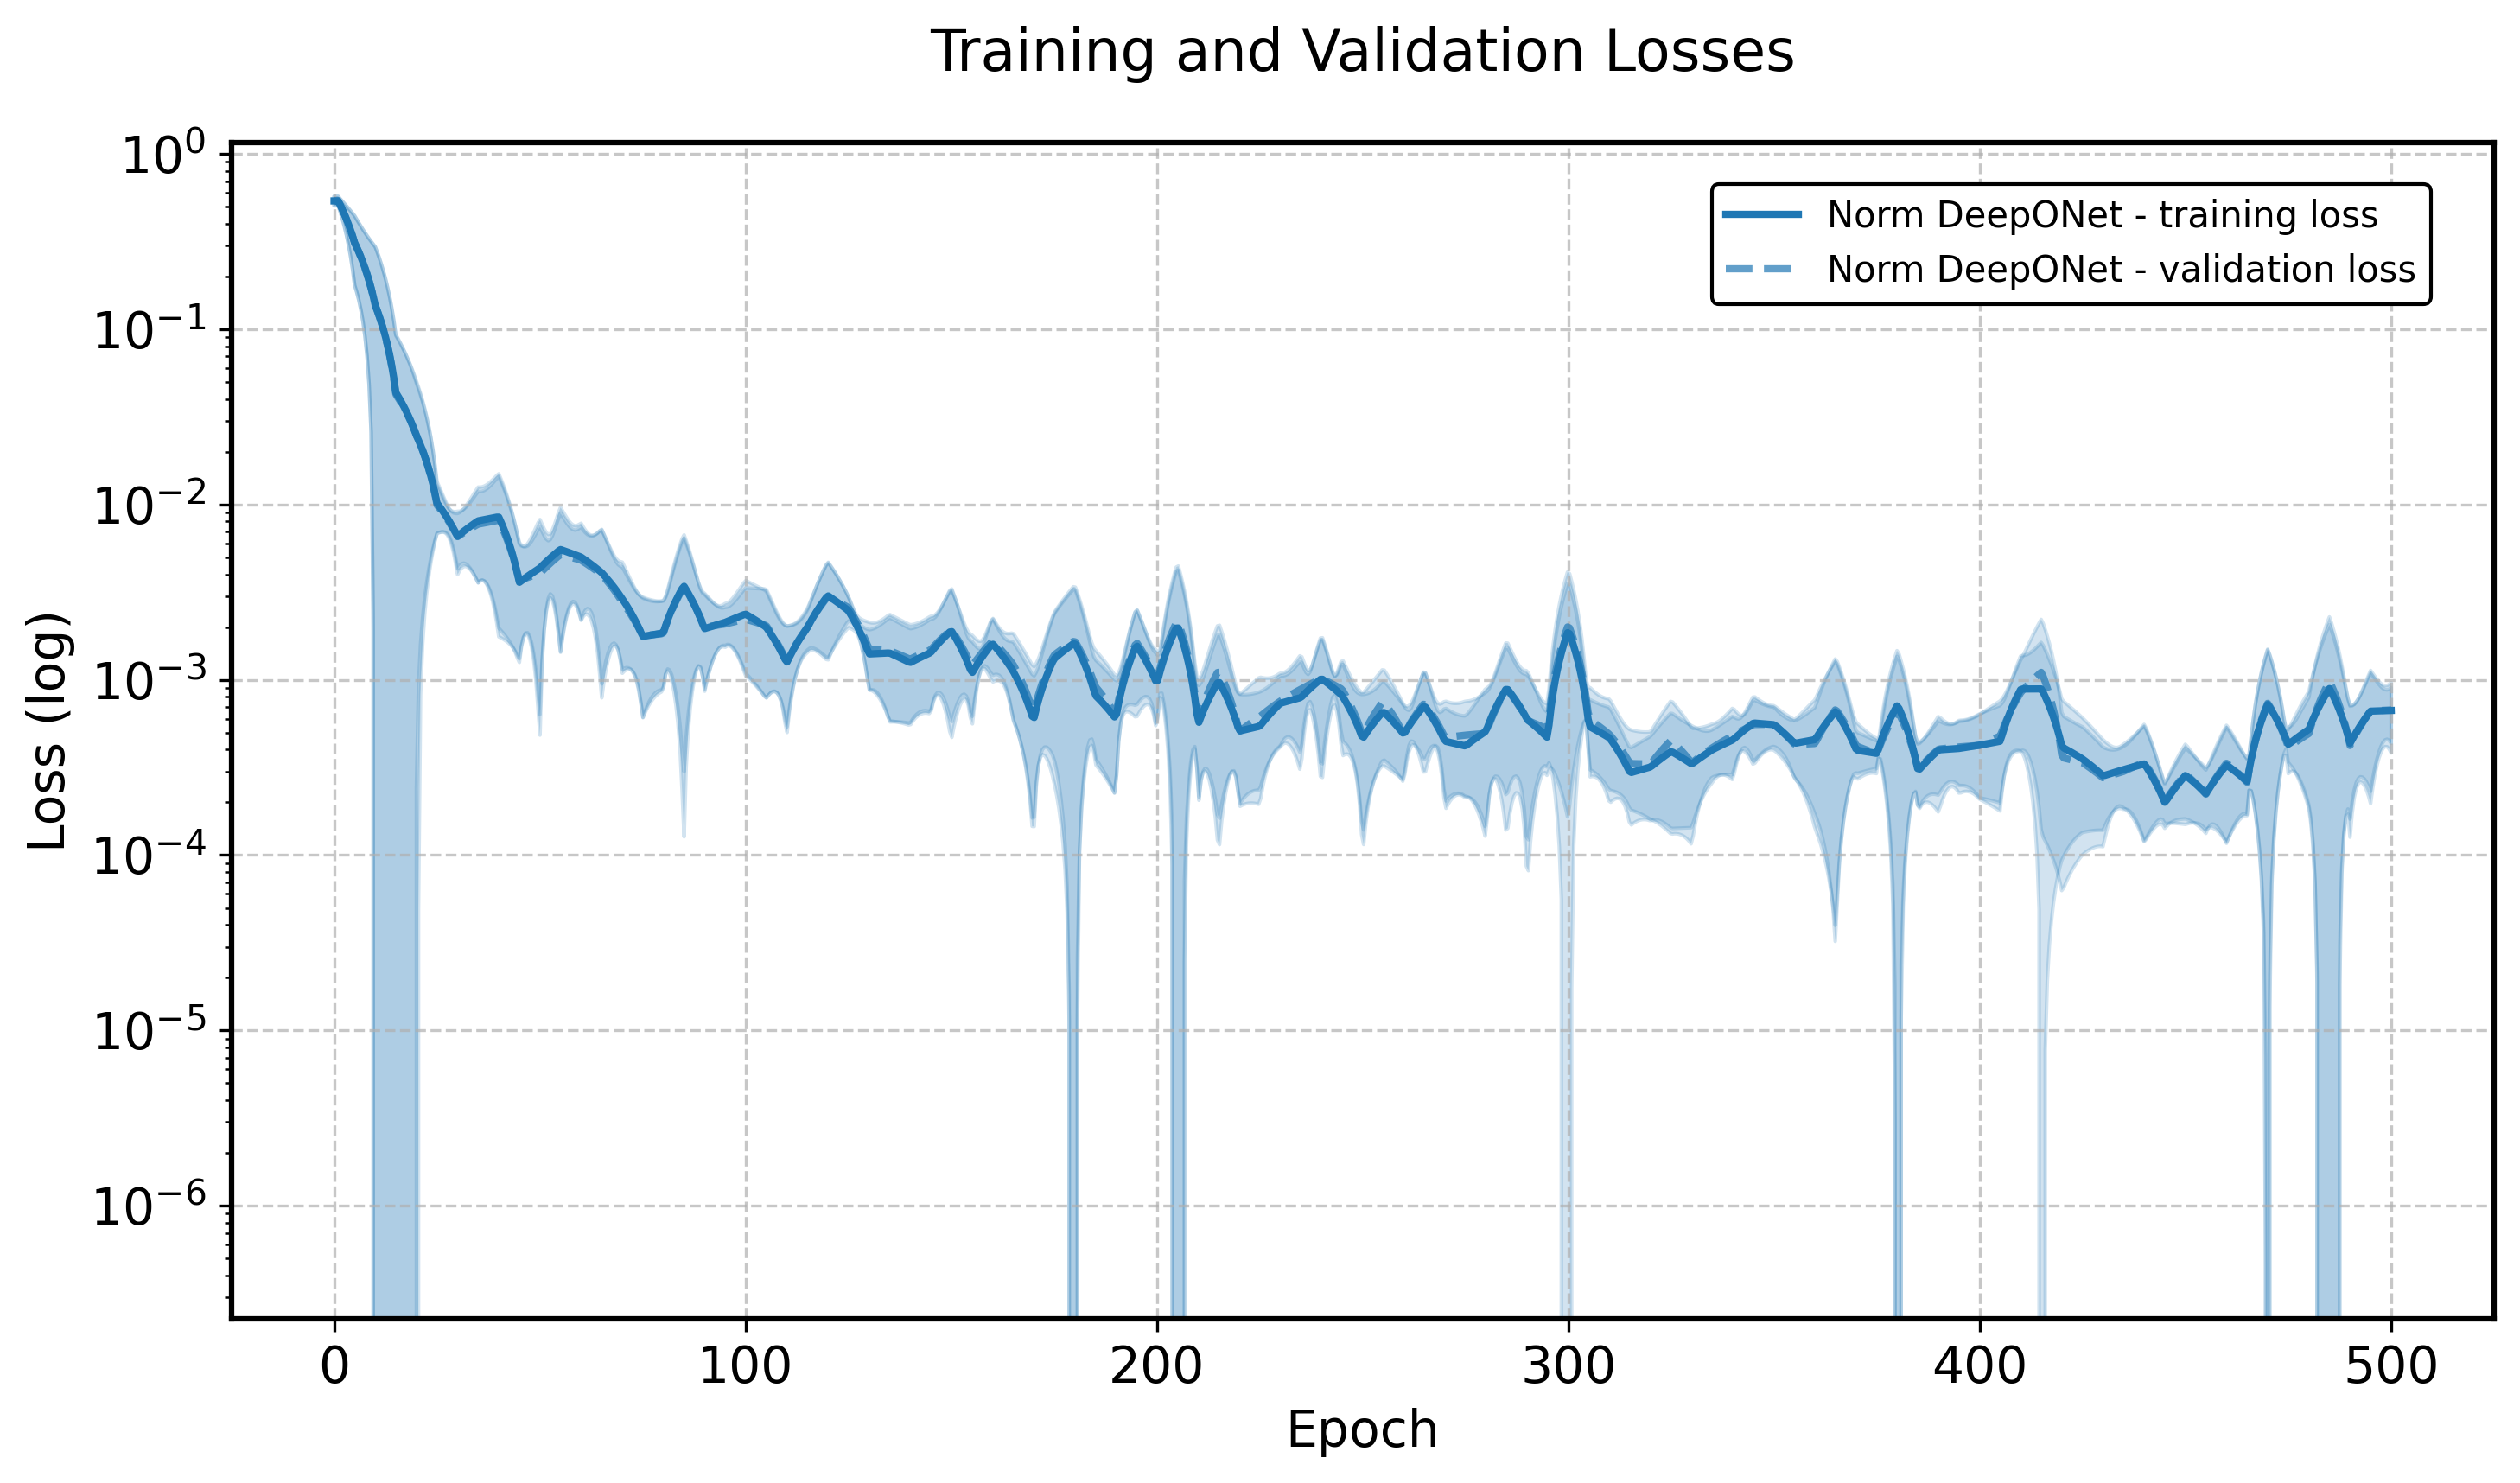

In [98]:
exp_data = [('Norm DeepONet',['20250410-134238','20250410-135050','20250410-135738','20250410-140424','20250410-141041'])]

wandb_viz_loss_with_std(exp_data, exclude=exclude, loss_types=loss_types)

In [72]:
def visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_dir):
    # List to store DataFrames
    dfs = []
    
    # Read all CSV files for the given parameters
    for exp_num in experiment_numbers:
        data_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/deeponet/experiments/{experiment_name}/exp_n_{exp_num}/plots'
        csv_path = f'{data_dir}/data_q0={q0:.2f}_p0={p0:.2f}_omega={omega:.2f}_val.csv'
        
        try:
            df = pd.read_csv(csv_path)
            dfs.append(df)
        except FileNotFoundError:
            print(f"Warning: File {csv_path} not found")
    
    if not dfs:
        print("No data files found")
        return
        
    # Calculate mean and std for each column
    combined_df = pd.concat(dfs)
    mean_df = combined_df.groupby('time').mean()
    std_df = combined_df.groupby('time').std()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1])
    
    colors = plt.cm.tab10(np.linspace(0, 1, 4))
    
    # Plot position/velocity data in first subplot
    ax1.plot(mean_df.index, mean_df['true_position'], '--', color=colors[0], label='true position')
    ax1.plot(mean_df.index, mean_df['predicted_position'], '-', color=colors[0], label='predicted position')
    ax1.fill_between(mean_df.index, 
                     mean_df['predicted_position'] - std_df['predicted_position'],
                     mean_df['predicted_position'] + std_df['predicted_position'],
                     color=colors[0], alpha=0.2)
    
    if 'true_velocity' in mean_df.columns:
        ax1.plot(mean_df.index, mean_df['true_velocity'], '--', color=colors[1], label='true velocity')
        ax1.plot(mean_df.index, mean_df['predicted_velocity'], '-', color=colors[1], label='predicted velocity')
        ax1.fill_between(mean_df.index,
                        mean_df['predicted_velocity'] - std_df['predicted_velocity'],
                        mean_df['predicted_velocity'] + std_df['predicted_velocity'],
                        color=colors[1], alpha=0.2)
    
    # Plot energy data in second subplot
    ax2.plot(mean_df.index, mean_df['true_energy'], '-', color=colors[2], label='true energy')
    ax2.plot(mean_df.index, mean_df['gradient_predicted_energy'], '-.', color=colors[3], label='gradient-predicted energy')
    ax2.fill_between(mean_df.index,
                     mean_df['gradient_predicted_energy'] - std_df['gradient_predicted_energy'],
                     mean_df['gradient_predicted_energy'] + std_df['gradient_predicted_energy'],
                     color=colors[3], alpha=0.2)
    
    if 'velocity_predicted_energy' in mean_df.columns:
        ax2.plot(mean_df.index, mean_df['velocity_predicted_energy'], '--', color=colors[2], label='velocity-predicted energy')
        ax2.fill_between(mean_df.index,
                        mean_df['velocity_predicted_energy'] - std_df['velocity_predicted_energy'],
                        mean_df['velocity_predicted_energy'] + std_df['velocity_predicted_energy'],
                        color=colors[2], alpha=0.2)
    
    # Set labels and titles
    ax1.set_ylabel('Position / Velocity', fontsize=14)
    ax1.set_title(f'Position and Velocity Predictions\n$q_0$={q0:.2f}, $p_0$={p0:.2f}, $\\omega$={omega:.2f}', fontsize=16, pad=20)
    ax1.grid(True)
    ax1.legend(fontsize=12)
    
    ax2.set_xlabel('Time', fontsize=14)
    ax2.set_ylabel('Energy', fontsize=14)
    ax2.set_title('Energy Predictions', fontsize=16, pad=20)
    ax2.grid(True)
    ax2.legend(fontsize=12)
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'{save_dir}/averaged_predictions_with_energy_q0={q0:.2f}_p0={p0:.2f}_omega={omega:.2f}_{experiment_label}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


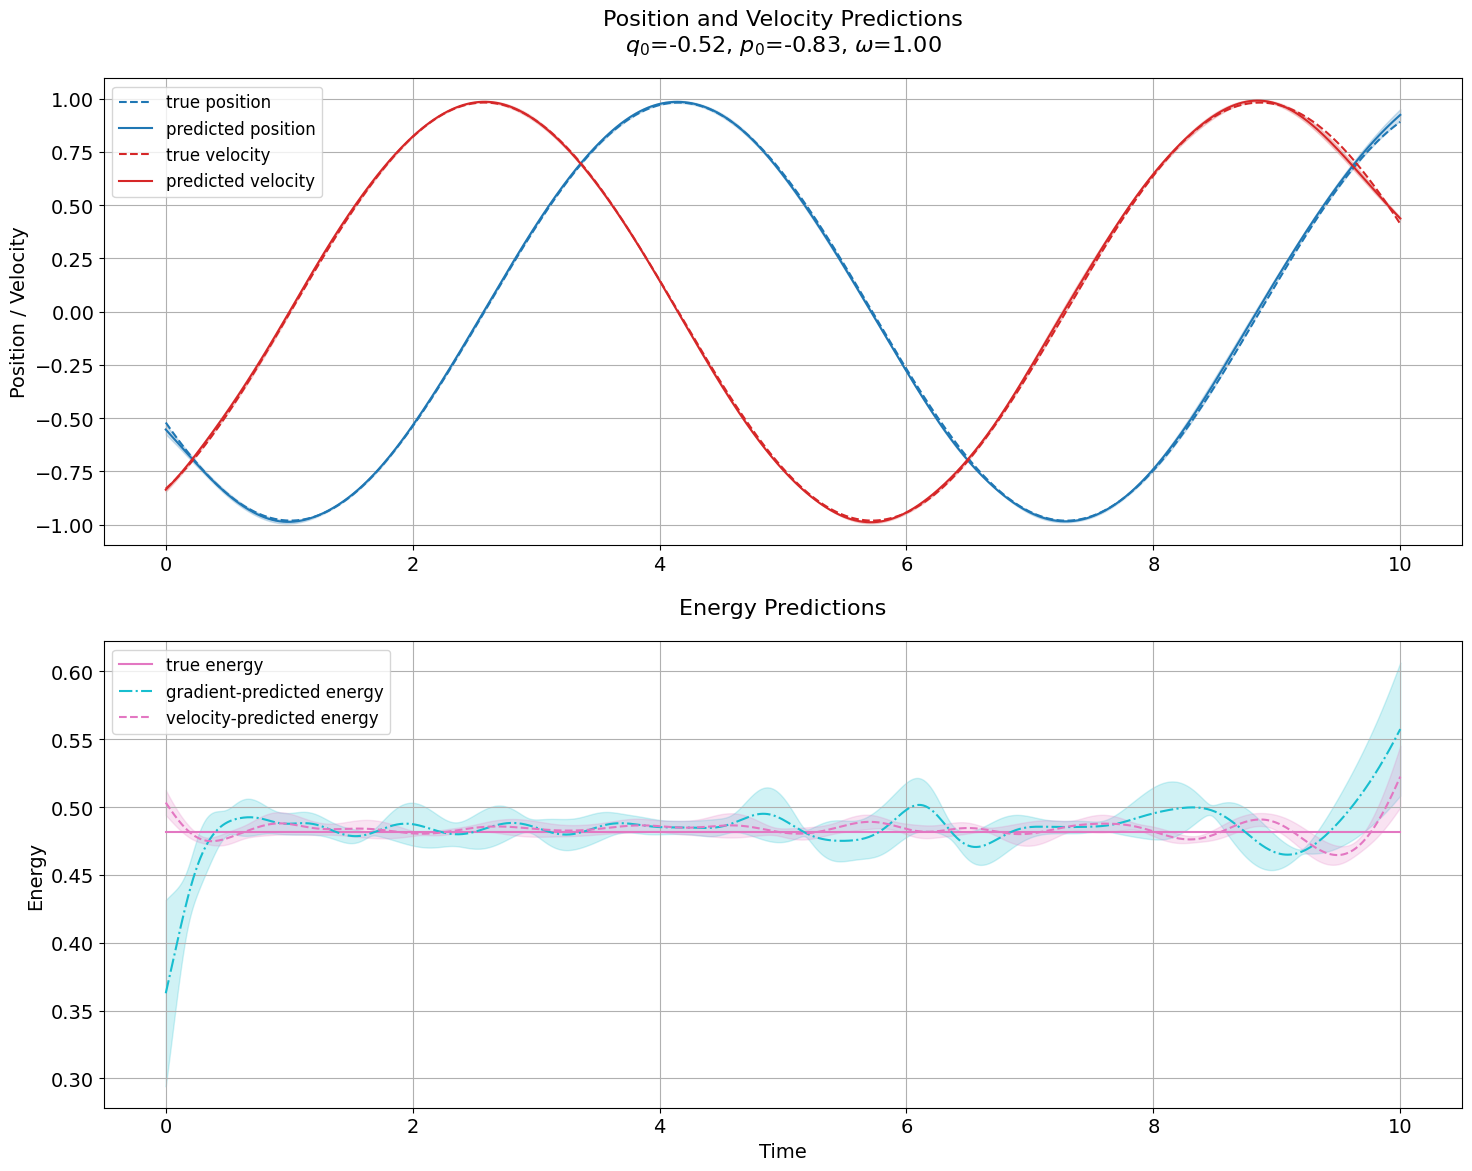

In [99]:
experiment_name = 'harmonic_osc_1_1'


save_plots_dir = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots'
experiment_label = 'Vanilla DeepONet'
experiment_numbers = ['20250410-113714', '20250410-114150','20250410-042930','20250410-114628','20250410-115127']

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)



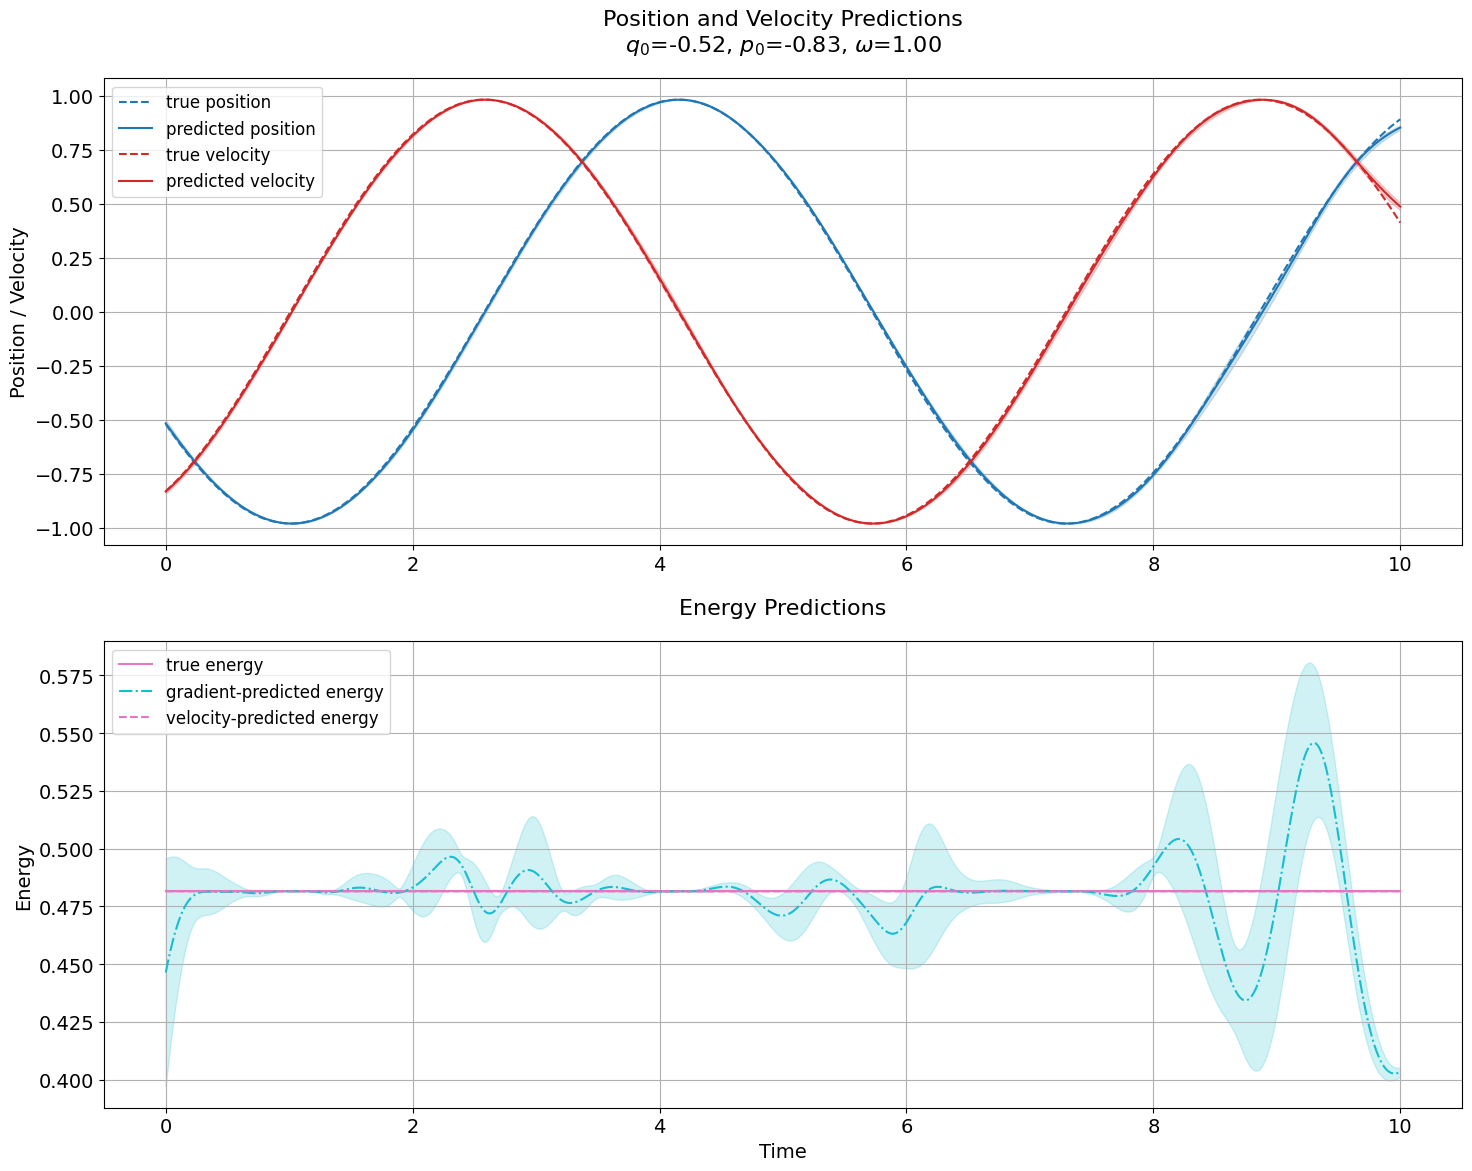

In [100]:
experiment_name = 'harmonic_osc_1_2'


save_plots_dir = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots'
experiment_label = 'QR DeepONet'
experiment_numbers = ['20250410-121129','20250410-122545','20250410-083757','20250410-123406','20250410-133226']

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)



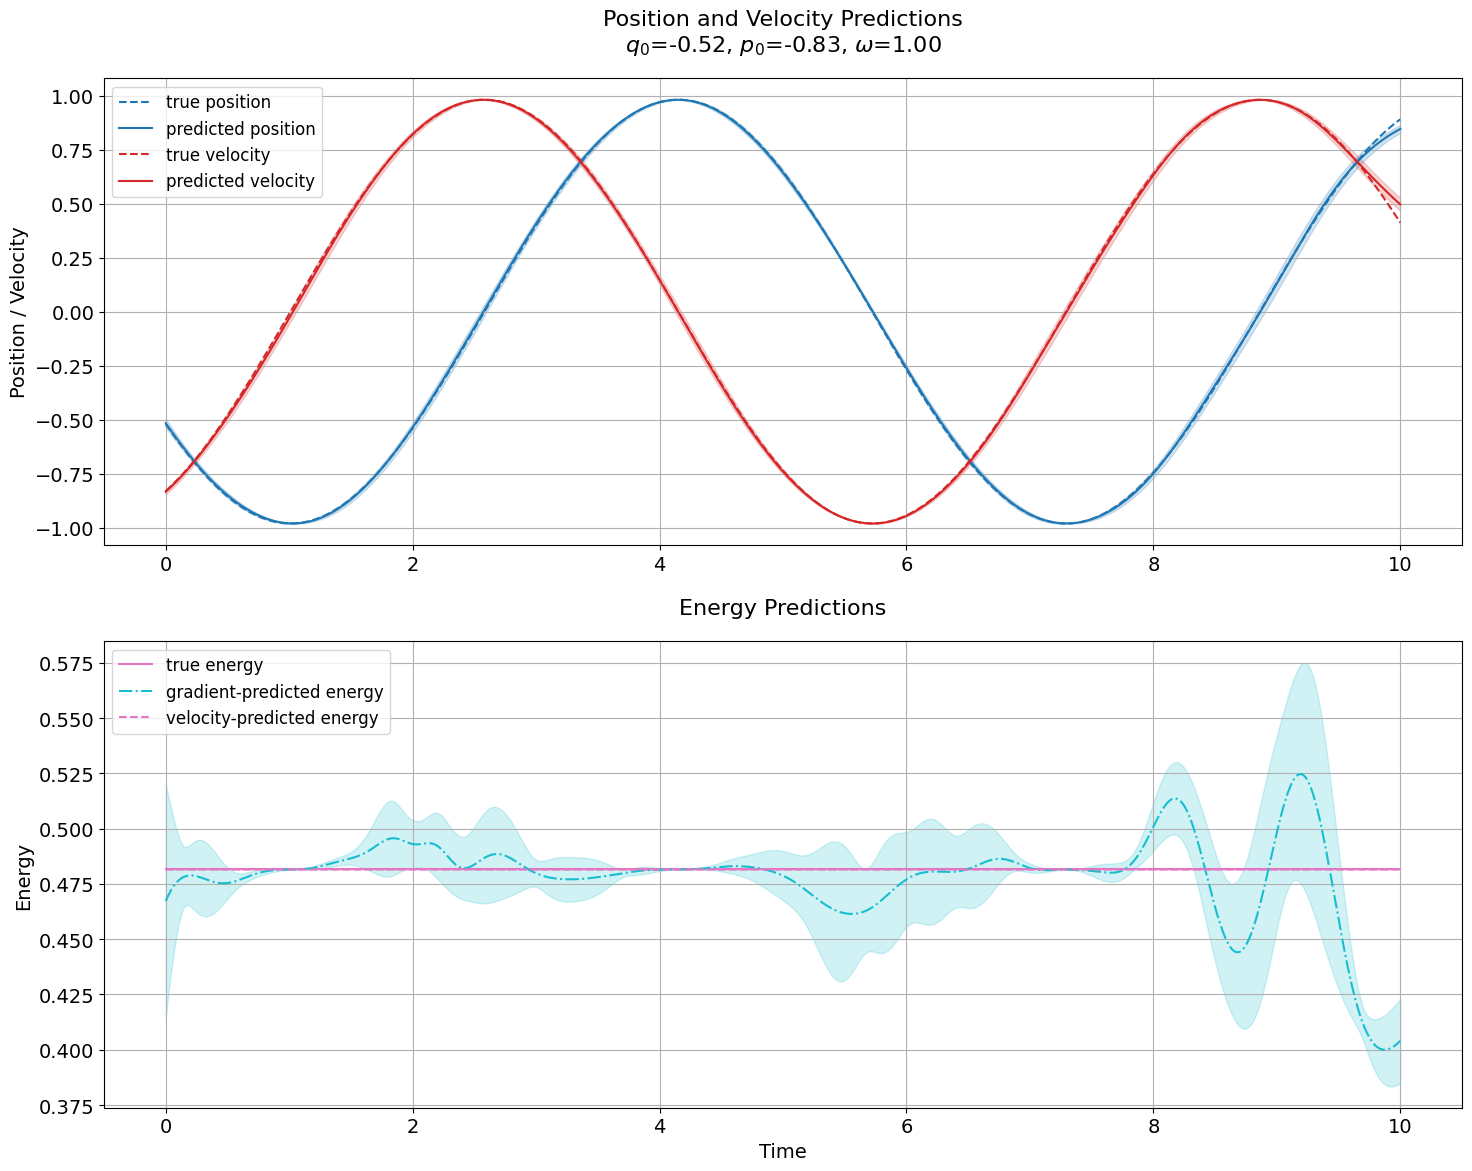

In [101]:
experiment_name = 'harmonic_osc_1_3'


save_plots_dir = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots'
experiment_label = 'Norm DeepONet'
experiment_numbers = ['20250410-134238','20250410-135050','20250410-135738','20250410-140424','20250410-141041']

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)

